In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import missingno as mno
import pickle
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)
import torch
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import NBEATSModel
from darts.metrics import mape, rmse
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from pytorch_lightning.callbacks import Callback, EarlyStopping
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances,
)
from darts.metrics import mape, rmse, mse, mae, r2_score,smape

pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

# Wrangling and Exploration

In [2]:
# load
df0 = pd.read_csv("energy_data.csv", header=0, parse_dates=["DateTime"])
dfw0 = pd.read_csv("weather_dataset.csv", header=0, parse_dates=["DateTime"])

In [3]:
df0.iloc[[0, -1]]

,DateTime,Tripura,Eastern Grid Total,Western Grid Total,Total (MW),Gas (Public),HVDC,Gas (Private),Oil (Private),Coal,Hydro,Oil (Public),Solar,Shortage
0,2018-01-01 00:00:00,90,"4,328.00","1,345.00","5,673.00","3,015.00",460,1715,292.00,169,79.00,200,0.00,0.00
43823,2022-12-31 23:00:00,100,"5,016.00","3,093.00","8,109.00","3,164.00",919,1589,"1,375.00",888,46.00,28,0.00,0.00


In [4]:
dfw0.iloc[[0, -1]]

,DateTime,maxtempC,mintempC,DewPointC,FeelsLikeC,HeatIndexC,cloudcover,humidity,pressure,tempC,winddirDegree,windspeedKmph,Area
0,2018-01-01 00:00:00,28,20,13,25,25,15,54,1013,22,259,3,BARISAL
394415,2022-12-31 23:00:00,27,11,6,14,14,2,59,1018,14,102,4,SYLHET


In [5]:
# backup of original sources
df1 = df0.copy()
dfw1 = dfw0.copy()

## Preparing the energy dataframe

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   DateTime            43824 non-null  datetime64[ns]
 1   Tripura             43824 non-null  int64         
 2   Eastern Grid Total  43824 non-null  float64       
 3   Western Grid Total  43824 non-null  float64       
 4   Total (MW)          43824 non-null  float64       
 5   Gas (Public)        43824 non-null  float64       
 6   HVDC                43824 non-null  int64         
 7   Gas (Private)       43824 non-null  int64         
 8   Oil (Private)       43824 non-null  float64       
 9   Coal                43824 non-null  int64         
 10  Hydro               43824 non-null  float64       
 11  Oil (Public)        43824 non-null  int64         
 12  Solar               43824 non-null  float64       
 13  Shortage            43824 non-null  float64   

In [7]:
# datetime
df1["DateTime"] = pd.to_datetime(df1["DateTime"], utc=True, infer_datetime_format=True)


# any duplicate time periods?
print("count of duplicates:",df1.duplicated(subset=["DateTime"], keep="first").sum())


df1.set_index("DateTime", inplace=True)


# any non-numeric types?
print("non-numeric columns:",list(df1.dtypes[df1.dtypes == "object"].index))


# any missing values?
def gaps(df):
    if df.isnull().values.any():
        print("MISSING values:\n")
        mno.matrix(df)
    else:
        print("no missing values\n")
gaps(df1)  


count of duplicates: 0
non-numeric columns: []
no missing values



In [8]:
# drop the NaN and zero columns, and also the 'forecast' columns
df1 = df1.drop('Shortage', axis=1)

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2018-01-01 00:00:00+00:00 to 2022-12-31 23:00:00+00:00
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Tripura             43824 non-null  int64  
 1   Eastern Grid Total  43824 non-null  float64
 2   Western Grid Total  43824 non-null  float64
 3   Total (MW)          43824 non-null  float64
 4   Gas (Public)        43824 non-null  float64
 5   HVDC                43824 non-null  int64  
 6   Gas (Private)       43824 non-null  int64  
 7   Oil (Private)       43824 non-null  float64
 8   Coal                43824 non-null  int64  
 9   Hydro               43824 non-null  float64
 10  Oil (Public)        43824 non-null  int64  
 11  Solar               43824 non-null  float64
dtypes: float64(7), int64(5)
memory usage: 4.3 MB


In [10]:
# rename columns
colnames_old = df1.columns
colnames_new = ["gen_tripura", "gen_east_grid", "gen_west_grid", "load_actual", \
                "gen_gas_pub", "gen_HVDC", "gen_gas_pri", "gen_oil_pri", \
                "gen_coal", "gen_hydro", "gen_oil_pub", "gen_solar"]
dict_cols = dict(zip(colnames_old, colnames_new))
df1.rename(columns=dict_cols, inplace=True)
print(df1.info())
df1.describe()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2018-01-01 00:00:00+00:00 to 2022-12-31 23:00:00+00:00
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gen_tripura    43824 non-null  int64  
 1   gen_east_grid  43824 non-null  float64
 2   gen_west_grid  43824 non-null  float64
 3   load_actual    43824 non-null  float64
 4   gen_gas_pub    43824 non-null  float64
 5   gen_HVDC       43824 non-null  int64  
 6   gen_gas_pri    43824 non-null  int64  
 7   gen_oil_pri    43824 non-null  float64
 8   gen_coal       43824 non-null  int64  
 9   gen_hydro      43824 non-null  float64
 10  gen_oil_pub    43824 non-null  int64  
 11  gen_solar      43824 non-null  float64
dtypes: float64(7), int64(5)
memory usage: 4.3 MB
None


,gen_tripura,gen_east_grid,gen_west_grid,load_actual,gen_gas_pub,gen_HVDC,gen_gas_pri,gen_oil_pri,gen_coal,gen_hydro,gen_oil_pub,gen_solar
count,"43,824.00","43,824.00","43,824.00","43,824.00","43,824.00","43,824.00","43,824.00","43,824.00","43,824.00","43,824.00","43,824.00","43,824.00"
mean,113.10,"6,070.73","2,671.05","8,741.86","3,651.81",679.25,"1,696.54","1,752.19",479.18,89.22,275.53,18.37
std,31.18,"1,317.31",837.45,"2,043.45",627.59,227.16,328.76,"1,168.44",297.70,49.33,331.30,40.32
min,0.00,168.00,1.00,"1,774.00",0.00,0.00,85.00,0.00,0.00,0.00,0.00,0.00
25%,90.00,"5,033.00","2,032.62","7,157.00","3,208.00",487.00,"1,466.00",772.00,235.00,46.00,10.00,0.00
50%,112.00,"6,051.75","2,637.85","8,658.80","3,703.00",717.00,"1,717.00","1,631.00",449.00,76.00,128.00,0.00
75%,136.00,"7,051.00","3,225.00","10,263.00","4,124.00",902.00,"1,941.00","2,579.25",650.00,123.00,462.00,16.00
max,198.00,"9,981.00","5,273.00","14,782.00","5,321.00",978.00,"2,839.00","5,460.00","1,514.00",271.00,"1,783.00",316.00


In [11]:
df1 = df1.reset_index()

In [12]:
from pandas.tseries.holiday import Holiday, AbstractHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Define a custom holiday calendar for Bangladesh
class BangladeshHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Year', month=1, day=1),
        Holiday('International Mother Language Day', month=2, day=21),
        Holiday('Sheikh Mujibur Rahman\'s birthday', month=3, day=17),
        Holiday('Independence Day', month=3, day=26),
        Holiday('Labor Day', month=5, day=1),
        Holiday('Eid al-Fitr', month=1, day=1, observance=pd.offsets.CustomBusinessDay(1, holidays=[])),
        Holiday('National Mourning Day', month=8, day=15),
        Holiday('Eid al-Adha', month=8, day=22, observance=pd.offsets.CustomBusinessDay(1, holidays=[])),
        Holiday('Ashura', month=1, day=1, observance=pd.offsets.CustomBusinessDay(1, holidays=[])),
        Holiday('Durga Puja', month=10, day=16, observance=pd.offsets.CustomBusinessDay(1, holidays=[])),
        Holiday('Victory Day', month=12, day=16),
        Holiday('Christmas Day', month=12, day=25)
    ]

# Create a custom business day offset that excludes holidays in Bangladesh
bangladesh_busday = CustomBusinessDay(calendar=BangladeshHolidayCalendar())

# Create a new column 'Holiday' and initialize with 0
df1['Holiday'] = 0

# Set the 'Holiday' column to 1 for the dates that are holidays in Bangladesh
for holiday in BangladeshHolidayCalendar().holidays(start='2018-01-01', end='2022-12-31'):
    df1.loc[df1['DateTime'].dt.date == holiday.date(), 'Holiday'] = 1


In [13]:
df1.set_index('DateTime', inplace= True)

In [14]:
# convert int and float64 columns to float32
intcols = list(df1.dtypes[df1.dtypes == np.int64].index)
df1[intcols] = df1[intcols].applymap(np.float32)

f64cols = list(df1.dtypes[df1.dtypes == np.float64].index)
df1[f64cols] = df1[f64cols].applymap(np.float32)

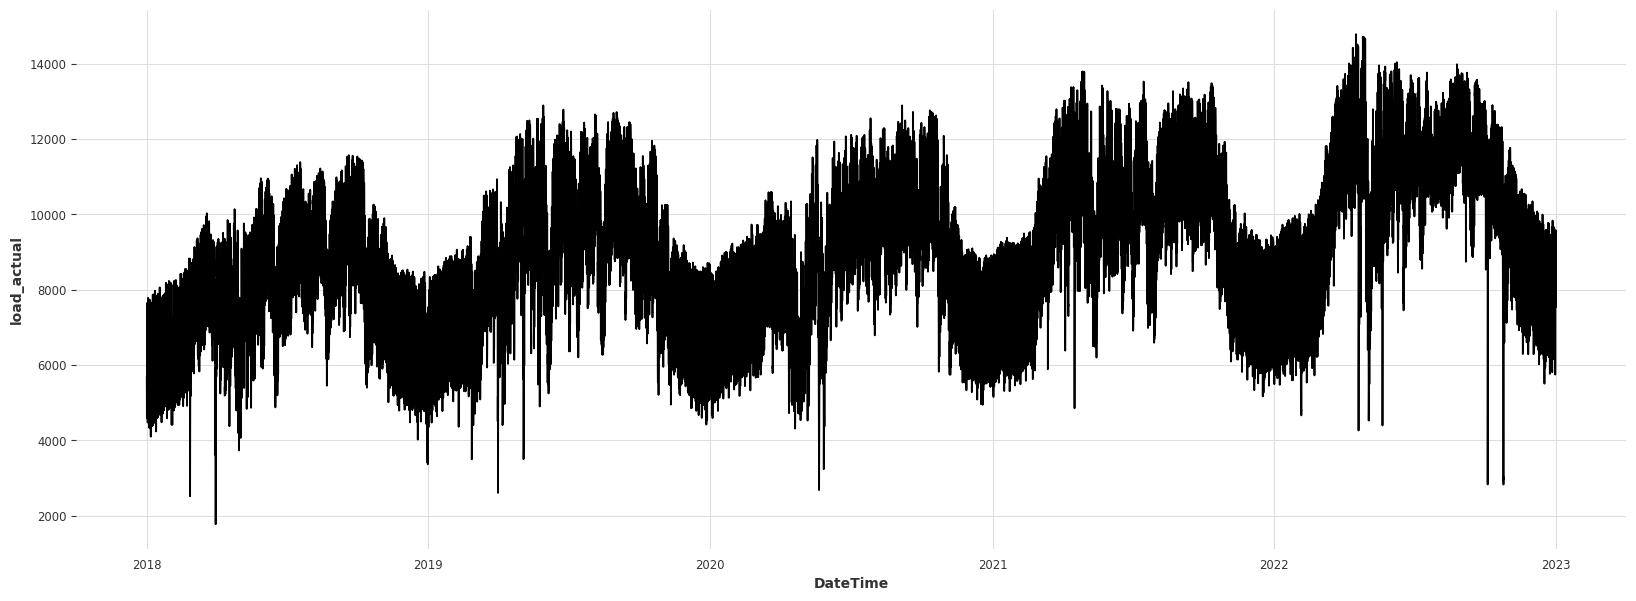

In [15]:
plt.figure(100, figsize=(20, 7))
sns.lineplot(x = "DateTime", y = "load_actual", data = df1, palette="coolwarm");

## Preparing the weather dataframe dfw1

In [16]:
dfw1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394416 entries, 0 to 394415
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   DateTime       394416 non-null  datetime64[ns]
 1   maxtempC       394416 non-null  int64         
 2   mintempC       394416 non-null  int64         
 3   DewPointC      394416 non-null  int64         
 4   FeelsLikeC     394416 non-null  int64         
 5   HeatIndexC     394416 non-null  int64         
 6   cloudcover     394416 non-null  int64         
 7   humidity       394416 non-null  int64         
 8   pressure       394416 non-null  int64         
 9   tempC          394416 non-null  int64         
 10  winddirDegree  394416 non-null  int64         
 11  windspeedKmph  394416 non-null  int64         
 12  Area           394416 non-null  object        
dtypes: datetime64[ns](1), int64(11), object(1)
memory usage: 39.1+ MB


In [17]:
# datetime
dfw1["DateTime"] = pd.to_datetime(dfw1["DateTime"], utc=True, infer_datetime_format=True)
dfw1.set_index("DateTime", inplace=True)


# any non-numeric types?
print("non-numeric columns:",list(dfw1.dtypes[dfw1.dtypes == "object"].index))


# any missing values?
def gaps(df):
    if df.isnull().values.any():
        print("MISSING values:\n")
        mno.matrix(df)
    else:
        print("no missing values\n")  
gaps(dfw1) 


dfw1.describe()

non-numeric columns: ['Area']
no missing values



,maxtempC,mintempC,DewPointC,FeelsLikeC,HeatIndexC,cloudcover,humidity,pressure,tempC,winddirDegree,windspeedKmph
count,"394,416.00","394,416.00","394,416.00","394,416.00","394,416.00","394,416.00","394,416.00","394,416.00","394,416.00","394,416.00","394,416.00"
mean,32.20,23.22,19.35,30.26,30.34,32.20,65.90,"1,008.05",27.25,176.37,10.44
std,3.91,4.02,6.36,6.52,6.42,30.68,20.07,5.41,4.75,88.51,5.97
min,16.00,9.00,-6.00,9.00,9.00,0.00,4.00,983.00,9.00,0.00,0.00
25%,30.00,20.00,14.00,26.00,26.00,4.00,51.00,"1,004.00",24.00,115.00,6.00
50%,32.00,24.00,22.00,30.00,30.00,22.00,69.00,"1,009.00",27.00,168.00,9.00
75%,34.00,26.00,25.00,35.00,35.00,58.00,83.00,"1,012.00",30.00,232.00,14.00
max,48.00,32.00,30.00,55.00,55.00,100.00,99.00,"1,022.00",48.00,360.00,98.00


In [18]:
# convert int and float64 columns to float32
intcols = list(dfw1.dtypes[dfw1.dtypes == np.int64].index)
dfw1[intcols] = dfw1[intcols].applymap(np.float32)

f64cols = list(dfw1.dtypes[dfw1.dtypes == np.float64].index)
dfw1[f64cols] = dfw1[f64cols].applymap(np.float32)

f32cols = list(dfw1.dtypes[dfw1.dtypes == np.float32].index)
dfw1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 394416 entries, 2018-01-01 00:00:00+00:00 to 2022-12-31 23:00:00+00:00
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   maxtempC       394416 non-null  float32
 1   mintempC       394416 non-null  float32
 2   DewPointC      394416 non-null  float32
 3   FeelsLikeC     394416 non-null  float32
 4   HeatIndexC     394416 non-null  float32
 5   cloudcover     394416 non-null  float32
 6   humidity       394416 non-null  float32
 7   pressure       394416 non-null  float32
 8   tempC          394416 non-null  float32
 9   winddirDegree  394416 non-null  float32
 10  windspeedKmph  394416 non-null  float32
 11  Area           394416 non-null  object 
dtypes: float32(11), object(1)
memory usage: 22.6+ MB


In [19]:
# start and end of energy and weather time series 
print("earliest weather time period:", dfw1.index.min())
print("latest weather time period:", dfw1.index.max())

print("earliest energy time period:", df1.index.min())
print("latest energy time period:", df1.index.max())

earliest weather time period: 2018-01-01 00:00:00+00:00
latest weather time period: 2022-12-31 23:00:00+00:00
earliest energy time period: 2018-01-01 00:00:00+00:00
latest energy time period: 2022-12-31 23:00:00+00:00


In [20]:
# cities in weather data
cities = dfw1["Area"].unique()
cities

array(['BARISAL', 'CHITTAGONG', 'COMILLA', 'DHAKA', 'KHULNA',
       'MYMENSINGH', 'RAJSHAHI', 'RANGPUR', 'SYLHET'], dtype=object)

In [21]:
dfw1 = dfw1.reset_index()
# drop duplicate time periods
print("count of duplicates before treatment:",dfw1.duplicated(subset=["DateTime", "Area"], keep="first").sum())

dfw1 = dfw1.drop_duplicates(subset=["DateTime", "Area"], keep="first")
dfw1.reset_index(drop=True, inplace=True)
print("count of duplicates after treatment:",dfw1.duplicated(subset=["DateTime", "Area"], keep="first").sum())

# set datetime index
dfw1["DateTime"] = pd.to_datetime(dfw1["DateTime"], utc=True, infer_datetime_format=True)
dfw1.set_index("DateTime", inplace=True)
# dfw1.drop("DateTime", inplace=True, axis=1)  # You don't need this line as DateTime is already set as index.

print("size of energy dataframe:", df1.shape[0])
dfw1_city = dfw1.groupby("Area").count()
dfw1_city


count of duplicates before treatment: 0
count of duplicates after treatment: 0
size of energy dataframe: 43824


,maxtempC,mintempC,DewPointC,FeelsLikeC,HeatIndexC,cloudcover,humidity,pressure,tempC,winddirDegree,windspeedKmph
Area,,,,,,,,,,,
BARISAL,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824
CHITTAGONG,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824
COMILLA,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824
DHAKA,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824
KHULNA,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824
MYMENSINGH,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824
RAJSHAHI,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824
RANGPUR,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824
SYLHET,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824


In [22]:
# count of weather observations by city
print("size of energy dataframe:", df1.shape[0])

dfw1["Area"] = dfw1["Area"].replace("BARISAL", "Barisal")
dfw1["Area"] = dfw1["Area"].replace("CHITTAGONG", "Chittagong")
dfw1["Area"] = dfw1["Area"].replace("COMILLA", "Comilla")
dfw1["Area"] = dfw1["Area"].replace("DHAKA", "Dhaka")
dfw1["Area"] = dfw1["Area"].replace("KHULNA", "Khulna")
dfw1["Area"] = dfw1["Area"].replace("MYMENSINGH", "Mymensingh")
dfw1["Area"] = dfw1["Area"].replace("RAJSHAHI", "Rajshahi")
dfw1["Area"] = dfw1["Area"].replace("RANGPUR", "Rangpur")
dfw1["Area"] = dfw1["Area"].replace("SYLHET", "Sylhet")

dfw1_city = dfw1.groupby("Area")
print("size of city groups in weather dataframe:")
dfw1_city.count()

size of energy dataframe: 43824
size of city groups in weather dataframe:


,maxtempC,mintempC,DewPointC,FeelsLikeC,HeatIndexC,cloudcover,humidity,pressure,tempC,winddirDegree,windspeedKmph
Area,,,,,,,,,,,
Barisal,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824
Chittagong,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824
Comilla,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824
Dhaka,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824
Khulna,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824
Mymensingh,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824
Rajshahi,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824
Rangpur,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824
Sylhet,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824,43824


In [23]:
# separate the cities: a weather dataframe for each of them
dict_city_weather = {city: dfw1[dfw1['Area'] == city] for city in dfw1['Area'].unique()}
dict_city_weather.keys()

dict_keys(['Barisal', 'Chittagong', 'Comilla', 'Dhaka', 'Khulna', 'Mymensingh', 'Rajshahi', 'Rangpur', 'Sylhet'])

In [24]:
# example: Bilbao weather dataframe
dfw_Dhaka = dict_city_weather.get("Dhaka")
print("Dhaka weather:")
dfw_Dhaka.describe()

Dhaka weather:


,maxtempC,mintempC,DewPointC,FeelsLikeC,HeatIndexC,cloudcover,humidity,pressure,tempC,winddirDegree,windspeedKmph
count,"43,824.00","43,824.00","43,824.00","43,824.00","43,824.00","43,824.00","43,824.00","43,824.00","43,824.00","43,824.00","43,824.00"
mean,33.14,24.16,18.95,31.34,31.41,31.79,60.63,"1,007.29",28.26,194.53,11.77
std,3.77,3.80,6.41,6.42,6.32,30.67,19.20,5.49,4.62,87.88,6.01
min,20.00,11.00,-1.00,11.00,13.00,0.00,8.00,988.00,11.00,0.00,0.00
25%,31.00,21.00,13.00,27.00,27.00,4.00,46.00,"1,003.00",26.00,143.00,8.00
50%,33.00,25.00,22.00,32.00,32.00,22.00,62.00,"1,007.00",28.00,179.00,10.00
75%,35.00,27.00,25.00,36.00,36.00,58.00,77.00,"1,012.00",31.00,261.00,15.00
max,46.00,31.00,28.00,53.00,53.00,100.00,99.00,"1,021.00",46.00,360.00,63.00


In [25]:
dfw_Dhaka.iloc[[0,-1]]

,maxtempC,mintempC,DewPointC,FeelsLikeC,HeatIndexC,cloudcover,humidity,pressure,tempC,winddirDegree,windspeedKmph,Area
DateTime,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,30.00,22.00,13.00,25.00,25.00,5.00,55.00,"1,012.00",23.00,273.00,2.00,Dhaka
2022-12-31 23:00:00+00:00,29.00,16.00,7.00,19.00,19.00,1.00,46.00,"1,017.00",19.00,22.00,8.00,Dhaka


In [26]:
# merge the energy and weather dataframes
df2 = df1.copy()
for city, df in dict_city_weather.items():
    city_name = str(city) + "_"
    df = df.add_suffix("_{}".format(city))
    df2 = pd.concat([df2, df], axis=1)
    if "city_name_" + city in df2.columns:
        df2.drop("city_name_" + city, inplace=True, axis=1)
print(df2.info())
df2.iloc[[0, -1]]


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2018-01-01 00:00:00+00:00 to 2022-12-31 23:00:00+00:00
Columns: 121 entries, gen_tripura to Area_Sylhet
dtypes: float32(112), object(9)
memory usage: 22.1+ MB
None


,gen_tripura,gen_east_grid,gen_west_grid,load_actual,gen_gas_pub,gen_HVDC,gen_gas_pri,gen_oil_pri,gen_coal,gen_hydro,...,DewPointC_Sylhet,FeelsLikeC_Sylhet,HeatIndexC_Sylhet,cloudcover_Sylhet,humidity_Sylhet,pressure_Sylhet,tempC_Sylhet,winddirDegree_Sylhet,windspeedKmph_Sylhet,Area_Sylhet
DateTime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,90.00,"4,328.00","1,345.00","5,673.00","3,015.00",460.00,"1,715.00",292.00,169.00,79.00,...,15.00,19.00,19.00,11.00,80.00,"1,013.00",19.00,101.00,2.00,Sylhet
2022-12-31 23:00:00+00:00,100.00,"5,016.00","3,093.00","8,109.00","3,164.00",919.00,"1,589.00","1,375.00",888.00,46.00,...,6.00,14.00,14.00,2.00,59.00,"1,018.00",14.00,102.00,4.00,Sylhet


In [27]:
# any null values?
print("any missing values?", df2.isnull().values.any())

# any ducplicate time periods?
print("count of duplicates:", df2.duplicated(keep="first").sum())

any missing values? False
count of duplicates: 0


In [28]:
df2_1 = df2.copy()

# Exploration of Combined Dataframe

In [29]:
# limit the dataframe's date range
#df2 = df2_1[(df2_1.index >= "2018-01-01 00:00:00+00:00") & (df2_1.index <= "2021-12-31 23:59:59+00:00")]
df2 = df2_1[(df2_1.index >= "2018-01-01 00:00:00+00:00")]
#df2_drift = df2_1[df2_1.index >= "2022-01-01 00:00:00+00:00"]
df2.iloc[[0,-1]]

,gen_tripura,gen_east_grid,gen_west_grid,load_actual,gen_gas_pub,gen_HVDC,gen_gas_pri,gen_oil_pri,gen_coal,gen_hydro,...,DewPointC_Sylhet,FeelsLikeC_Sylhet,HeatIndexC_Sylhet,cloudcover_Sylhet,humidity_Sylhet,pressure_Sylhet,tempC_Sylhet,winddirDegree_Sylhet,windspeedKmph_Sylhet,Area_Sylhet
DateTime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,90.00,"4,328.00","1,345.00","5,673.00","3,015.00",460.00,"1,715.00",292.00,169.00,79.00,...,15.00,19.00,19.00,11.00,80.00,"1,013.00",19.00,101.00,2.00,Sylhet
2022-12-31 23:00:00+00:00,100.00,"5,016.00","3,093.00","8,109.00","3,164.00",919.00,"1,589.00","1,375.00",888.00,46.00,...,6.00,14.00,14.00,2.00,59.00,"1,018.00",14.00,102.00,4.00,Sylhet


In [30]:
# Drop non-numeric columns
df2_numeric = df2.select_dtypes(exclude='object')

In [31]:
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select the target column
target_col = 'load_actual'


# Prepare the features and target data
X = df2_numeric.drop(columns=[target_col])
y = df2_numeric[target_col]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Create the LGBMRegressor model
lgbm_model = LGBMRegressor()

# Perform RFE using the LGBMRegressor model
rfe = RFE(estimator=lgbm_model, n_features_to_select=25, step=1)
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X.columns[rfe.support_]

# Print the selected features
print("Selected features:")
print(selected_features)

# Create a new dataframe with the selected features and target
selected_df = df2_numeric[selected_features.to_list() + [target_col]]


Selected features:
Index(['gen_tripura', 'gen_east_grid', 'gen_west_grid', 'gen_gas_pub',
       'gen_HVDC', 'gen_gas_pri', 'gen_oil_pri', 'gen_coal', 'gen_hydro',
       'gen_oil_pub', 'winddirDegree_Barisal', 'cloudcover_Chittagong',
       'humidity_Comilla', 'winddirDegree_Comilla', 'cloudcover_Dhaka',
       'winddirDegree_Dhaka', 'windspeedKmph_Dhaka', 'cloudcover_Khulna',
       'winddirDegree_Khulna', 'windspeedKmph_Khulna', 'FeelsLikeC_Mymensingh',
       'cloudcover_Mymensingh', 'winddirDegree_Rajshahi', 'humidity_Rangpur',
       'winddirDegree_Rangpur'],
      dtype='object')


In [32]:
df2 = selected_df

In [33]:
# check correlations of features with load
df_corr = df2.corr(method="pearson")
print(df_corr.shape)
print("correlation with load:")
df_corrP = pd.DataFrame(df_corr["load_actual"].sort_values(ascending=False))
df_corrP

(26, 26)
correlation with load:


,load_actual
load_actual,1.00
gen_east_grid,0.97
gen_west_grid,0.92
gen_oil_pri,0.90
gen_tripura,0.72
gen_HVDC,0.66
gen_gas_pri,0.58
gen_oil_pub,0.52
FeelsLikeC_Mymensingh,0.51
gen_coal,0.50


In [34]:
# highest absolute correlations with load
pd.options.display.float_format = '{:,.2f}'.format
df_corrH = df_corrP[np.abs(df_corrP["load_actual"]) > 0.0]
df_corrH

,load_actual
load_actual,1.00
gen_east_grid,0.97
gen_west_grid,0.92
gen_oil_pri,0.90
gen_tripura,0.72
gen_HVDC,0.66
gen_gas_pri,0.58
gen_oil_pub,0.52
FeelsLikeC_Mymensingh,0.51
gen_coal,0.50


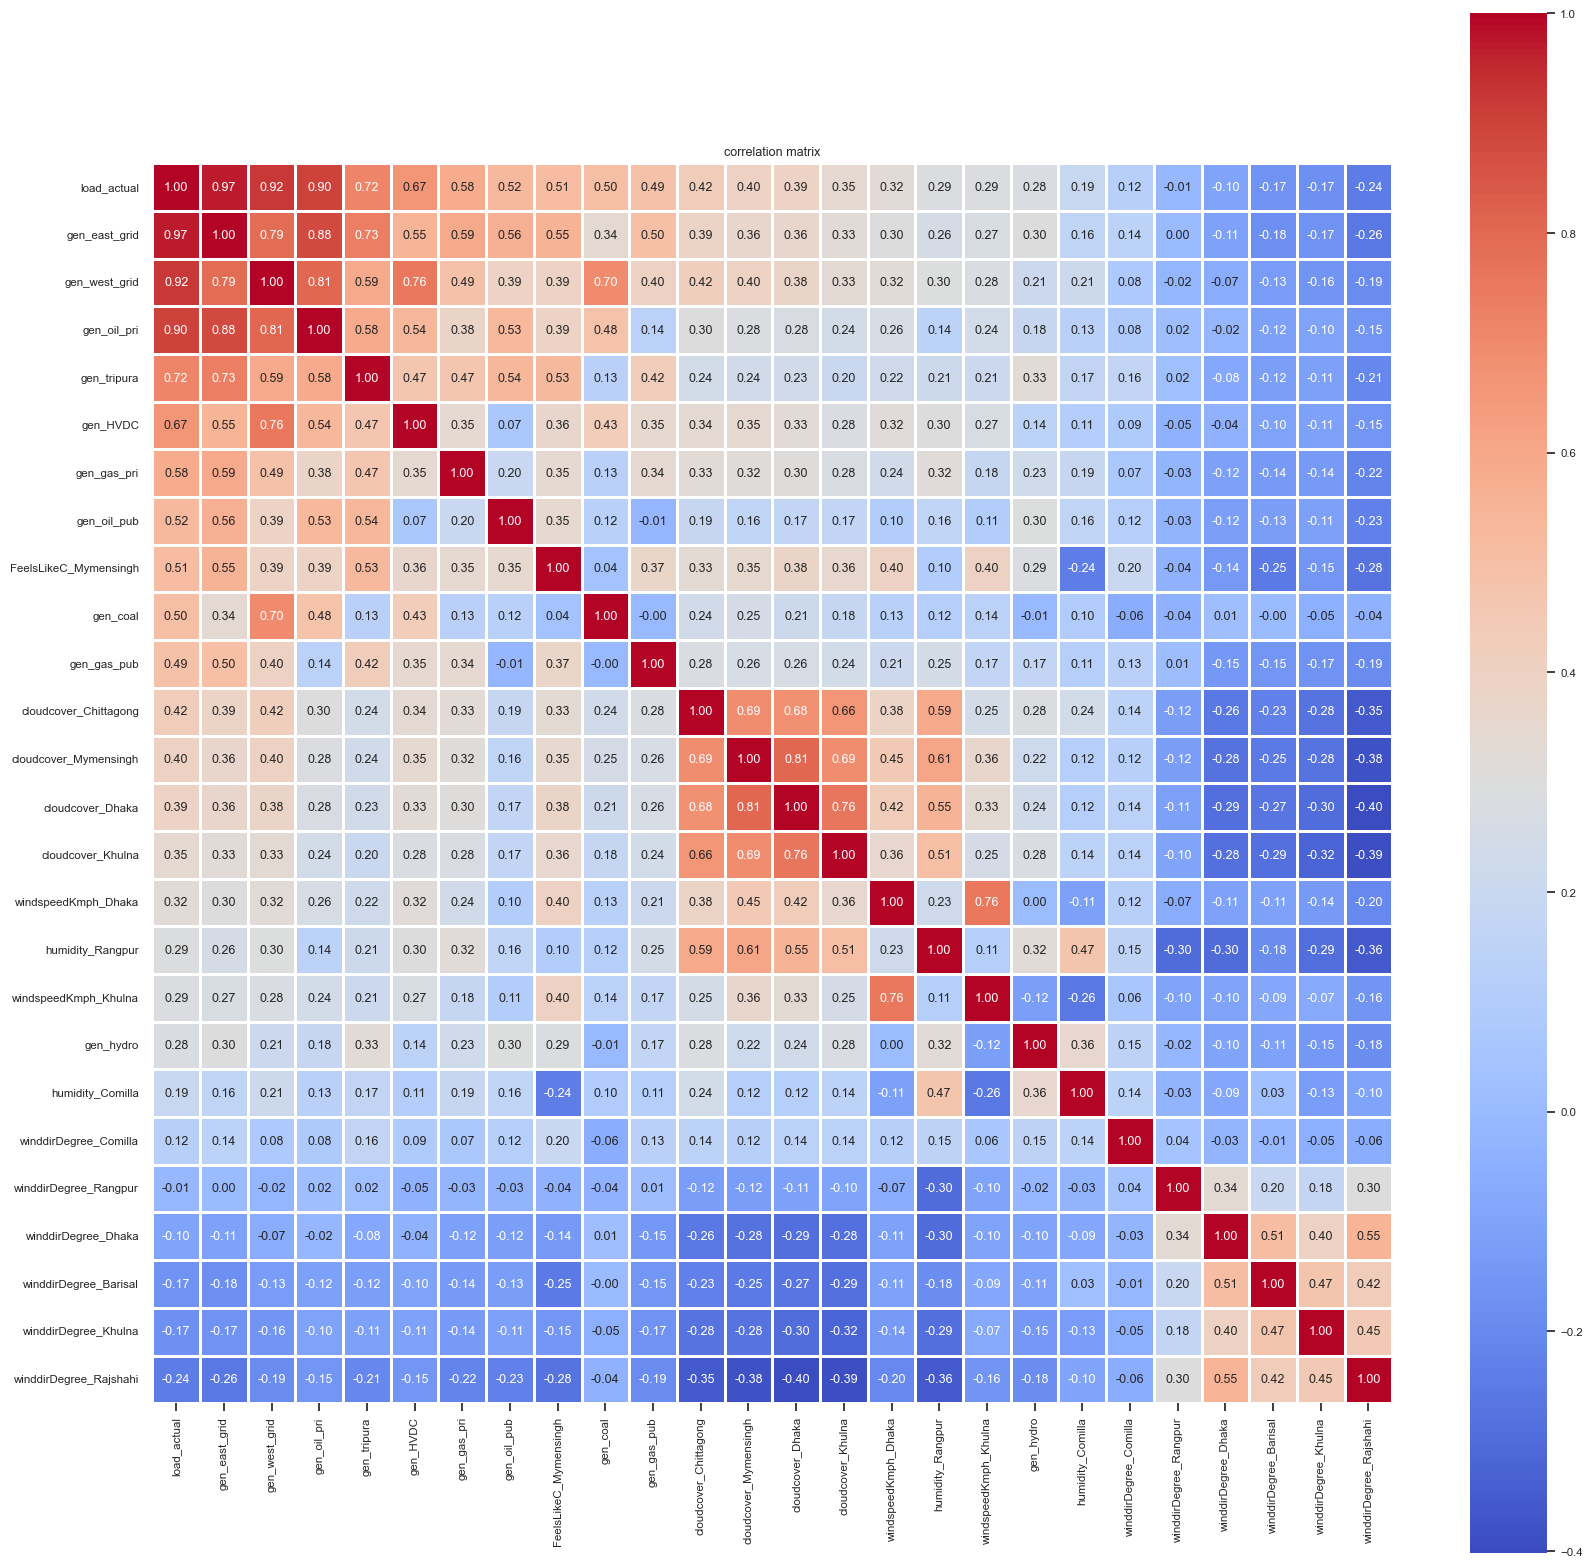

In [35]:
# correlation matrix, limited to highly correlated features
df3 = df2[df_corrH.index]

idx = df3.corr().sort_values("load_actual", ascending=False).index
df3_sorted = df3.loc[:, idx]  # sort dataframe columns by their correlation with Appliances

plt.figure(figsize = (20,20))
sns.set(font_scale=0.75)
ax = sns.heatmap(df3_sorted.corr().round(3), 
            annot=True, 
            square=True, 
            linewidths=.75, cmap="coolwarm", 
            fmt = ".2f", 
            annot_kws = {"size": 9})
ax.xaxis.tick_bottom()
plt.title("correlation matrix")
plt.show()

In [36]:
# limit energy dataframe to columns that have 
# at least a moderate correlation with price
df3 = df2[df_corrH.index]
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2018-01-01 00:00:00+00:00 to 2022-12-31 23:00:00+00:00
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   load_actual             43824 non-null  float32
 1   gen_east_grid           43824 non-null  float32
 2   gen_west_grid           43824 non-null  float32
 3   gen_oil_pri             43824 non-null  float32
 4   gen_tripura             43824 non-null  float32
 5   gen_HVDC                43824 non-null  float32
 6   gen_gas_pri             43824 non-null  float32
 7   gen_oil_pub             43824 non-null  float32
 8   FeelsLikeC_Mymensingh   43824 non-null  float32
 9   gen_coal                43824 non-null  float32
 10  gen_gas_pub             43824 non-null  float32
 11  cloudcover_Chittagong   43824 non-null  float32
 12  cloudcover_Mymensingh   43824 non-null  float32
 13  cloudcover_Dhaka        43824 non-null  floa

In [37]:
# additional datetime columns: feature engineering
df3["month"] = df3.index.month

df3["wday"] = df3.index.dayofweek
dict_days = {0:"1_Mon", 1:"2_Tue", 2:"3_Wed", 3:"4_Thu", 4:"5_Fri", 5:"6_Sat", 6:"7_Sun"}
df3["weekday"] = df3["wday"].apply(lambda x: dict_days[x])

df3["hour"] = df3.index.hour

df3 = df3.astype({"hour":float, "wday":float, "month": float})

df3.iloc[[0, -1]]

,load_actual,gen_east_grid,gen_west_grid,gen_oil_pri,gen_tripura,gen_HVDC,gen_gas_pri,gen_oil_pub,FeelsLikeC_Mymensingh,gen_coal,...,winddirDegree_Comilla,winddirDegree_Rangpur,winddirDegree_Dhaka,winddirDegree_Barisal,winddirDegree_Khulna,winddirDegree_Rajshahi,month,wday,weekday,hour
DateTime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,"5,673.00","4,328.00","1,345.00",292.00,90.00,460.00,"1,715.00",200.00,26.00,169.00,...,283.00,36.00,273.00,259.00,344.00,305.00,1.00,0.00,1_Mon,0.00
2022-12-31 23:00:00+00:00,"8,109.00","5,016.00","3,093.00","1,375.00",100.00,919.00,"1,589.00",28.00,17.00,888.00,...,99.00,86.00,22.00,67.00,75.00,47.00,12.00,5.00,6_Sat,23.00


In [38]:
# dataframe with load and features only
df4 = df3.copy()
df4.drop(["weekday", "month", "wday", "hour"], inplace=True, axis=1)

# Time Series Object

In [39]:
# create time series object for target variable
ts_P = TimeSeries.from_series(df4["load_actual"]) 

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['load_actual'], dtype='object', name='component')
duration: 1825 days 23:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [40]:
# create time series object for the feature columns
df_covF = df4.loc[:, df4.columns != "load_actual"]
ts_covF = TimeSeries.from_dataframe(df_covF)

# check attributes of the time series
print("components (columns) of feature time series:", ts_covF.components)
print("duration:",ts_covF.duration)
print("frequency:",ts_covF.freq)
print("frequency:",ts_covF.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_covF.has_datetime_index)
print("deterministic:",ts_covF.is_deterministic)
print("univariate:",ts_covF.is_univariate)


components (columns) of feature time series: Index(['gen_east_grid', 'gen_west_grid', 'gen_oil_pri', 'gen_tripura',
       'gen_HVDC', 'gen_gas_pri', 'gen_oil_pub', 'FeelsLikeC_Mymensingh',
       'gen_coal', 'gen_gas_pub', 'cloudcover_Chittagong',
       'cloudcover_Mymensingh', 'cloudcover_Dhaka', 'cloudcover_Khulna',
       'windspeedKmph_Dhaka', 'humidity_Rangpur', 'windspeedKmph_Khulna',
       'gen_hydro', 'humidity_Comilla', 'winddirDegree_Comilla',
       'winddirDegree_Rangpur', 'winddirDegree_Dhaka', 'winddirDegree_Barisal',
       'winddirDegree_Khulna', 'winddirDegree_Rajshahi'],
      dtype='object', name='component')
duration: 1825 days 23:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: False


In [41]:
# example: operating with time series objects:
# we can also create a 3-dimensional numpy array from a time series object
# 3 dimensions: time (rows) / components (columns) / samples
ar_covF = ts_covF.all_values()
print(type(ar_covF))
ar_covF.shape

<class 'numpy.ndarray'>


(43824, 25, 1)

In [42]:
# example: operating with time series objects:
# we can also create a pandas series or dataframe from a time series object
df_covF = ts_covF.pd_dataframe()
type(df_covF)

pandas.core.frame.DataFrame

In [43]:
SPLIT_TRAIN = 0.6
SPLIT_VAL = 0.2
SPLIT_TEST = 0.2
# Calculate indices for splitting
train_idx = int(len(ts_P) * SPLIT_TRAIN)
val_idx = int(len(ts_P) * (SPLIT_TRAIN + SPLIT_VAL))

# Train/val/test split
ts_train = ts_P[:train_idx]
ts_val = ts_P[train_idx:val_idx]
ts_test = ts_P[val_idx:]

print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("Validation start:", ts_val.start_time())
print("Validation end:", ts_val.end_time())
print("Validation duration:", ts_val.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)


scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_tval = scalerP.transform(ts_val)
ts_ttest = scalerP.transform(ts_test)
ts_t = scalerP.transform(ts_P)

# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_tval = ts_tval.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

print("first and last row of scaled price time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

training start: 2018-01-01 00:00:00
training end: 2020-12-31 13:00:00
training duration: 1095 days 13:00:00
Validation start: 2020-12-31 14:00:00
Validation end: 2021-12-31 18:00:00
Validation duration: 365 days 04:00:00
test start: 2021-12-31 19:00:00
test end: 2022-12-31 23:00:00
test duration: 365 days 04:00:00
first and last row of scaled price time series:


component,load_actual
DateTime,
2018-01-01 00:00:00,0.35
2022-12-31 23:00:00,0.57


In [44]:
# Calculate indices for splitting
train_idx = int(len(ts_covF) * SPLIT_TRAIN)
val_idx = int(len(ts_covF) * (SPLIT_TRAIN + SPLIT_VAL))

# Train/val/test split for feature covariates
covF_train = ts_covF[:train_idx]
covF_val = ts_covF[train_idx:val_idx]
covF_test = ts_covF[val_idx:]

# Scale feature covariates
scalerF = Scaler()
scalerF.fit_transform(covF_train)
covF_ttrain = scalerF.transform(covF_train)
covF_tval = scalerF.transform(covF_val)
covF_ttest = scalerF.transform(covF_test)
covF_t = scalerF.transform(ts_covF)

# Make sure data are of type float
covF_ttrain = covF_ttrain.astype(np.float32)
covF_tval = covF_tval.astype(np.float32)
covF_ttest = covF_ttest.astype(np.float32)

pd.options.display.float_format = '{:.2f}'.format
print("first and last row of scaled feature covariates:")
covF_t.pd_dataframe().iloc[[0, -1]]


first and last row of scaled feature covariates:


component,gen_east_grid,gen_west_grid,gen_oil_pri,gen_tripura,gen_HVDC,gen_gas_pri,gen_oil_pub,FeelsLikeC_Mymensingh,gen_coal,gen_gas_pub,...,humidity_Rangpur,windspeedKmph_Khulna,gen_hydro,humidity_Comilla,winddirDegree_Comilla,winddirDegree_Rangpur,winddirDegree_Dhaka,winddirDegree_Barisal,winddirDegree_Khulna,winddirDegree_Rajshahi
DateTime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0.34,0.30,0.06,0.46,0.47,0.60,0.11,0.34,0.17,0.50,...,0.59,0.05,0.29,0.81,0.79,0.10,0.76,0.72,0.96,0.85
2022-12-31 23:00:00,0.44,0.68,0.30,0.52,0.94,0.55,0.02,0.11,0.87,0.53,...,0.41,0.08,0.17,0.78,0.28,0.24,0.06,0.19,0.21,0.13


In [45]:
# Feature engineering - create time covariates: hour, weekday, month, year, country-specific holidays
covT = datetime_attribute_timeseries(ts_P.time_index, attribute="hour")
covT = covT.stack(datetime_attribute_timeseries(covT.time_index, attribute="day_of_week"))
covT = covT.stack(datetime_attribute_timeseries(covT.time_index, attribute="month"))
covT = covT.stack(datetime_attribute_timeseries(covT.time_index, attribute="year"))

# Train/val/test split for time covariates
covT_train = covT[:train_idx]
covT_val = covT[train_idx:val_idx]
covT_test = covT[val_idx:]

covT_val_extended = covT_val.pd_dataframe()
additional_time_index = pd.date_range(start=covT_val_extended.index[-1] + pd.Timedelta(hours=1),
                                      periods=48, freq='H')
additional_rows = pd.DataFrame(index=additional_time_index, columns=covT_val_extended.columns)
covT_val_extended = covT_val_extended.append(additional_rows)
covT_val_extended = TimeSeries.from_dataframe(covT_val_extended)

# Rescale the covariates: fitting on the training set
scalerT = Scaler()
scalerT.fit(covT_train)
covT_ttrain = scalerT.transform(covT_train)
covT_tval = scalerT.transform(covT_val_extended)  # Use the extended val set here
covT_ttest = scalerT.transform(covT_test)
covT_t = scalerT.transform(covT)

covT_t = covT_t.astype(np.float32)
covT_ttrain = covT_ttrain.astype(np.float32)
covT_tval = covT_tval.astype(np.float32)
covT_ttest = covT_ttest.astype(np.float32)

pd.options.display.float_format = '{:.0f}'.format
print("first and last row of unscaled time covariates:")
covT.pd_dataframe().iloc[[0, -1]]


first and last row of unscaled time covariates:


component,hour,day_of_week,month,year
DateTime,,,,
2018-01-01 00:00:00,0,0,1,2018
2022-12-31 23:00:00,23,5,12,2022


In [46]:
# Combine feature and time covariates along component dimension: axis=1
ts_cov = ts_covF.concatenate(covT.slice_intersect(ts_covF), axis=1)  # unscaled F+T
cov_t = covF_t.concatenate(covT_t.slice_intersect(covF_t), axis=1)  # scaled F+T
cov_ttrain = covF_ttrain.concatenate(covT_ttrain.slice_intersect(covF_ttrain), axis=1)  # scaled F+T training set
cov_tval = covF_tval.concatenate(covT_tval.slice_intersect(covF_tval), axis=1)  # scaled F+T validation set
cov_ttest = covF_ttest.concatenate(covT_ttest.slice_intersect(covF_ttest), axis=1)  # scaled F+T test set

pd.options.display.float_format = '{:.2f}'.format
print("first and last row of unscaled covariates:")
ts_cov.pd_dataframe().iloc[[0, -1]]


first and last row of unscaled covariates:


component,gen_east_grid,gen_west_grid,gen_oil_pri,gen_tripura,gen_HVDC,gen_gas_pri,gen_oil_pub,FeelsLikeC_Mymensingh,gen_coal,gen_gas_pub,...,winddirDegree_Comilla,winddirDegree_Rangpur,winddirDegree_Dhaka,winddirDegree_Barisal,winddirDegree_Khulna,winddirDegree_Rajshahi,hour,day_of_week,month,year
DateTime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,4328.00,1345.00,292.00,90.00,460.00,1715.00,200.00,26.00,169.00,3015.00,...,283.00,36.00,273.00,259.00,344.00,305.00,0.00,0.00,1.00,2018.00
2022-12-31 23:00:00,5016.00,3093.00,1375.00,100.00,919.00,1589.00,28.00,17.00,888.00,3164.00,...,99.00,86.00,22.00,67.00,75.00,47.00,23.00,5.00,12.00,2022.00


In [47]:
print("covF_ttrain start:", covF_ttrain.start_time())
print("covF_ttrain end:", covF_ttrain.end_time())
print("covF_tval start:", covF_tval.start_time())
print("covF_tval end:", covF_tval.end_time())
print("covF_ttest start:", covF_ttest.start_time())
print("covF_ttest end:", covF_ttest.end_time())

print("covT_ttrain start:", covT_ttrain.start_time())
print("covT_ttrain end:", covT_ttrain.end_time())
print("covT_tval start:", covT_tval.start_time())
print("covT_tval end:", covT_tval.end_time())
print("covT_ttest start:", covT_ttest.start_time())
print("covT_ttest end:", covT_ttest.end_time())


covF_ttrain start: 2018-01-01 00:00:00
covF_ttrain end: 2020-12-31 13:00:00
covF_tval start: 2020-12-31 14:00:00
covF_tval end: 2021-12-31 18:00:00
covF_ttest start: 2021-12-31 19:00:00
covF_ttest end: 2022-12-31 23:00:00
covT_ttrain start: 2018-01-01 00:00:00
covT_ttrain end: 2020-12-31 13:00:00
covT_tval start: 2020-12-31 14:00:00
covT_tval end: 2022-01-02 18:00:00
covT_ttest start: 2021-12-31 19:00:00
covT_ttest end: 2022-12-31 23:00:00


## Training, Hyperparamter tuning and testing: NBEATS

In [48]:
LOAD = False         # True = load previously saved model from disk?  False = (re)train the model
SAVE = "\_NBEATS_model_ad_full.pt"   # file name to save the model under
mpath = r'c:\\Users\\sakif\\Downloads\\Paper\\BEST MODELS' + SAVE 

In [49]:
def build_fit_nbeats_model(
    input_chunk_length,
    output_chunk_length,
    num_stacks,
    num_blocks,
    layer_widths,
    num_layers,
    dropout,
    lr,
    callbacks=None,
):
    
    # reproducibility
    torch.manual_seed(42)

    batch_size = 64
    n_epochs = 70
    nr_epochs_val_period = 1
    QUANTILES =[
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]

    # Monitor validation loss for early stopping
    early_stopper = EarlyStopping("val_loss", min_delta=0.005, patience=5, verbose=True)
    if callbacks is None:
        callbacks = [early_stopper]
    else:
        callbacks = [early_stopper] + callbacks

    # detect if a GPU is available
    if torch.cuda.is_available():
        pl_trainer_kwargs = {
            "accelerator": "gpu",
            "callbacks": callbacks,
        }
        num_workers = 4
    else:
        pl_trainer_kwargs = {"callbacks": callbacks}
        num_workers = 0

    # Build the TFT model
    model = NBEATSModel(
        input_chunk_length=input_chunk_length,
        output_chunk_length=output_chunk_length,
        num_stacks=num_stacks,
        num_blocks=num_blocks,
        num_layers=num_layers,
        layer_widths=layer_widths,
        dropout=dropout,
        optimizer_kwargs={"lr": lr},
        batch_size=batch_size,
        n_epochs=n_epochs,
        nr_epochs_val_period=nr_epochs_val_period,
        likelihood=QuantileRegression(QUANTILES),
        model_name="nbeats_model1",
        log_tensorboard=True,
        generic_architecture=True, 
        force_reset=True,
        save_checkpoints=True,
        pl_trainer_kwargs=pl_trainer_kwargs,
    )
    
    # Train the model
    model.fit(
        series=ts_ttrain,
        past_covariates=cov_t,
        val_series=ts_tval,
        val_past_covariates=cov_t,
        verbose=True,
    )
    model = NBEATSModel.load_from_checkpoint("nbeats_model1")

    return model


In [50]:
QUANTILES =[
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]

In [51]:
from optuna.integration import PyTorchLightningPruningCallback
from pytorch_lightning import Callback

class CustomPyTorchLightningPruningCallback(Callback):
    def __init__(self, trial, monitor="val_loss"):
        self._trial = trial
        self._monitor = monitor

    def on_validation_end(self, trainer, pl_module):
        logs = trainer.callback_metrics
        current_score = logs.get(self._monitor)
        if current_score is None:
            return
        self._trial.report(current_score, step=trainer.global_step)
        if self._trial.should_prune():
            message = f"Trial was pruned at step {trainer.global_step}."
            raise optuna.TrialPruned(message)


In [52]:
def objective(trial):
    callback = [CustomPyTorchLightningPruningCallback(trial, monitor="val_loss")]

    input_chunk_length = trial.suggest_categorical("input_chunk_length", [12, 24, 48, 72, 168])
    num_stacks = trial.suggest_categorical("num_stacks", [1, 2, 3, 4])
    layer_widths = trial.suggest_categorical('layer_widths', [64, 128, 256, 512])
    num_blocks = trial.suggest_categorical('num_blocks', [1, 2, 3, 4])
    num_layers = trial.suggest_categorical('num_layers', [1, 2, 3, 4])
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)

    # build and train the TFT model with these hyper-parameters:
    nbeats_model = build_fit_nbeats_model(
        input_chunk_length=input_chunk_length,
        output_chunk_length = 1,
        num_stacks=num_stacks,
        num_blocks=num_blocks,
        num_layers=num_layers,
        layer_widths=layer_widths,
        lr=lr,
        dropout=dropout,
        callbacks=callback
    )

    # Evaluate how good it is on the validation set
    preds = nbeats_model.predict(n=len(ts_tval), num_samples=100, n_jobs=3, verbose=True)
    error = mape(preds, ts_tval)

    return error if error != np.nan else float("inf")


def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


study = optuna.create_study(direction="minimize")

study.optimize(objective, n_trials=100, callbacks=[print_callback])

# We could also have used a command as follows to limit the number of trials instead:
# study.optimize(objective, n_trials=100, callbacks=[print_callback])

# Finally, print the best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

best_params = study.best_trial.params


# training: load a saved model or (re)train
if LOAD:
    print("have loaded a previously saved model from disk:" + mpath)
    best_model = NBEATSModel.load(mpath)
else:
    best_model = build_fit_nbeats_model(
            input_chunk_length=best_params["input_chunk_length"],
            output_chunk_length=1,
            num_stacks=best_params["num_stacks"],
            num_blocks=best_params["num_blocks"],
            num_layers=best_params["num_layers"],
            layer_exp=best_params["layer_exp"],
            lr=best_params["lr"],
            dropout=best_params["dropout"])
    
    print("have saved the model after training:", mpath)
    best_model.save(mpath)

In [53]:
# training: load a saved model or (re)train
if LOAD:
    print("have loaded a previously saved model from disk:" + mpath)
    best_model = NBEATSModel.load(mpath)
else:
    best_model = build_fit_nbeats_model(
            input_chunk_length=24,
            output_chunk_length=1,
            num_stacks=1,
            num_blocks=4,
            num_layers=3,
            layer_widths=128,
            lr=0.0004511081825539187,
            dropout=0.2149897334912223)
    
    print("have saved the model after training:", mpath)
    best_model.save(mpath)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

have saved the model after training: c:\\Users\\sakif\\Downloads\\Paper\\BEST MODELS\_NBEATS_model_ad_full.pt


In [54]:
best_preds = best_model.predict(
                                    n=len(ts_tval), 
                                    past_covariates=cov_t, 
                                    num_samples=1000,   
                                    n_jobs=3, 
                                    verbose=True
)

Predicting: 0it [00:00, ?it/s]

In [55]:
nbeats_mape = mape(scalerP.inverse_transform(best_preds), ts_val)
nbeats_rmse = rmse(scalerP.inverse_transform(best_preds), ts_val)
nbeats_mse = mse(scalerP.inverse_transform(best_preds), ts_val)
nbeats_r2 = r2_score(scalerP.inverse_transform(best_preds), ts_val)
nbeats_smape = smape(scalerP.inverse_transform(best_preds), ts_val)
nbeats_mae = mae(scalerP.inverse_transform(best_preds), ts_val)


In [56]:
nbeats_mape, nbeats_rmse, nbeats_mse, nbeats_r2, nbeats_smape, nbeats_mae

(2.3697209299214563,
 294.5951507941158,
 86786.30287140782,
 0.9742511025633466,
 2.388733845159727,
 218.8660394959088)

In [57]:
q50_RMSE = np.inf
q50_MAPE = np.inf
ts_q50 = None
pd.options.display.float_format = '{:,.2f}'.format
dfY_nbeats = pd.DataFrame()
dfY_nbeats["Actual"] = TimeSeries.pd_series(ts_val)
def predQ(ts_t, q):
    ts_tq = ts_t.quantile_timeseries(q)
    ts_q = scalerP.inverse_transform(ts_tq)
    s = TimeSeries.pd_series(ts_q)
    header = "Q" + format(int(q*100), "02d")
    dfY_nbeats[header] = s
    if q==0.5:
        ts_q50 = ts_q
        q50_RMSE = rmse(ts_q50, ts_val)
        q50_MAPE = mape(ts_q50, ts_val) 
        print("RMSE:", f'{q50_RMSE:.2f}')
        print("MAPE:", f'{q50_MAPE:.2f}')
  
# call helper function predQ, once for every quantile
_ = [predQ(best_preds, q) for q in QUANTILES]

# move Q50 column to the left of the Actual column
col = dfY_nbeats.pop("Q50")
dfY_nbeats.insert(1, col.name, col)
dfY_nbeats.iloc[np.r_[0:2, -2:0]]


RMSE: 294.60
MAPE: 2.37


,Actual,Q50,Q01,Q05,Q10,Q15,Q20,Q25,Q30,Q40,Q60,Q70,Q75,Q80,Q85,Q90,Q95,Q99
DateTime,,,,,,,,,,,,,,,,,,
2020-12-31 14:00:00,"7,237.00","7,365.52","6,676.27","6,972.21","7,072.63","7,080.19","7,130.62","7,146.34","7,197.08","7,328.15","7,422.71","7,444.69","7,453.15","7,493.46","7,543.51","7,589.49","7,692.58","7,790.73"
2020-12-31 15:00:00,"6,976.00","7,291.68","6,713.27","6,967.22","7,017.64","7,054.41","7,087.07","7,127.31","7,202.71","7,259.17","7,336.89","7,376.98","7,407.97","7,433.39","7,472.59","7,511.68","7,626.20","7,777.35"
2021-12-31 17:00:00,"6,112.00","6,420.22","5,547.75","5,906.99","6,055.86","6,107.67","6,168.35","6,208.88","6,269.70","6,380.23","6,500.33","6,632.96","6,668.15","6,699.43","6,747.35","6,817.26","6,887.62","7,141.36"
2021-12-31 18:00:00,"7,708.00","7,835.59","6,854.08","7,161.43","7,388.08","7,431.61","7,546.30","7,601.52","7,632.90","7,782.46","7,960.89","8,080.31","8,129.32","8,179.27","8,276.47","8,360.09","8,466.04","8,851.69"


In [58]:
import plotly.graph_objs as go

def plot_actual_vs_q50(df):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=df.index, y=df['Actual'], mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=df.index, y=df['Q50'], mode='lines', name='Q50'))

    fig.update_layout(title='Actual vs Q50 Load Data (Validation set)', xaxis_title='DateTime', yaxis_title='Load Value')

    fig.show()


# Plot the actual vs Q50 values
plot_actual_vs_q50(dfY_nbeats)


In [59]:
# Make predictions on the unseen test data
best_nbeats_test = best_model.predict(
    series=ts_ttrain.concatenate(ts_tval),
    past_covariates=cov_t, 
    n=len(ts_ttest),
    num_samples=1000,
    n_jobs=3,
    verbose=True
)

Predicting: 0it [00:00, ?it/s]

In [60]:
error = mape(best_nbeats_test, ts_ttest)
error

3.293193766970447

In [61]:
q50_RMSE = np.inf
q50_MAPE = np.inf
ts_q50 = None
pd.options.display.float_format = '{:,.2f}'.format
dfY_nbeats1 = pd.DataFrame()
dfY_nbeats1["Actual"] = TimeSeries.pd_series(ts_test)


In [62]:
def predQ(ts_t, q):
    ts_tq = ts_t.quantile_timeseries(q)
    ts_q = scalerP.inverse_transform(ts_tq)
    s = TimeSeries.pd_series(ts_q)
    header = "Q" + format(int(q*100), "02d")
    dfY_nbeats1[header] = s
    if q==0.5:
        ts_q50 = ts_q
        q50_RMSE = rmse(ts_q50, ts_test)
        q50_MAPE = mape(ts_q50, ts_test) 
        print("RMSE:", f'{q50_RMSE:.2f}')
        print("MAPE:", f'{q50_MAPE:.2f}')
  
# call helper function predQ, once for every quantile
_ = [predQ(best_nbeats_test, q) for q in QUANTILES]

# move Q50 column to the left of the Actual column
col = dfY_nbeats1.pop("Q50")
dfY_nbeats1.insert(1, col.name, col)
dfY_nbeats1.iloc[np.r_[0:2, -2:0]]

RMSE: 353.64
MAPE: 2.65


,Actual,Q50,Q01,Q05,Q10,Q15,Q20,Q25,Q30,Q40,Q60,Q70,Q75,Q80,Q85,Q90,Q95,Q99
DateTime,,,,,,,,,,,,,,,,,,
2021-12-31 19:00:00,"8,193.00","8,612.30","7,850.45","8,120.31","8,206.59","8,241.16","8,324.74","8,337.67","8,428.01","8,548.44","8,704.36","8,727.17","8,746.45","8,783.20","8,833.79","8,986.53","9,007.41","9,093.91"
2021-12-31 20:00:00,"8,192.00","8,526.79","7,814.25","8,162.02","8,224.91","8,265.61","8,301.24","8,327.47","8,401.24","8,486.83","8,571.70","8,603.79","8,630.90","8,658.77","8,702.11","8,769.79","8,796.95","8,902.67"
2022-12-31 22:00:00,"8,697.00","8,621.90","7,933.35","8,279.63","8,368.16","8,422.53","8,477.60","8,499.58","8,523.49","8,593.37","8,684.35","8,714.29","8,757.97","8,779.82","8,846.76","8,920.69","8,969.90","9,235.15"
2022-12-31 23:00:00,"8,109.00","8,118.15","7,413.89","7,749.61","7,854.20","7,888.49","7,932.23","7,953.42","8,036.50","8,089.49","8,162.37","8,203.56","8,239.45","8,263.71","8,300.80","8,335.01","8,417.98","8,686.44"


In [63]:
import plotly.graph_objs as go

def plot_actual_vs_q50(df):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=df.index, y=df['Actual'], mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=df.index, y=df['Q50'], mode='lines', name='Q50'))

    fig.update_layout(title='Actual vs Q50 Load Data (Test Set)', xaxis_title='DateTime', yaxis_title='Load Value')

    fig.show()


# Plot the actual vs Q50 values
plot_actual_vs_q50(dfY_nbeats1)


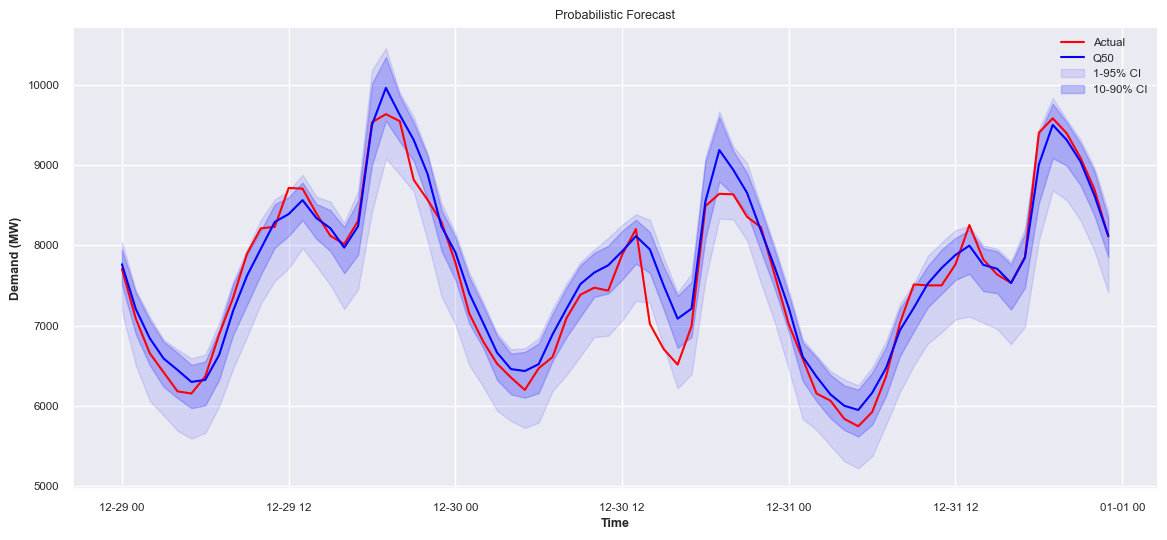

In [64]:
import matplotlib.pyplot as plt

# Prepare the data
actual_data = dfY_nbeats1["Actual"][-72:]
q50_data = dfY_nbeats1["Q50"][-72:]

# Plot the actual data and Q50 predictions
plt.figure(figsize=(14, 6))
plt.plot(actual_data, label="Actual", color="red")
plt.plot(q50_data, label="Q50", color="blue")

# Plot the confidence intervals (quantiles) as shaded areas
for i, (q1, q2) in enumerate([(0.01, 0.95), (0.1, 0.9)]):
    col1 = f"Q{int(q1 * 100):02d}"
    col2 = f"Q{int(q2 * 100):02d}"
    plt.fill_between(
        dfY_nbeats1.index[-72:],
        dfY_nbeats1[col1][-72:],
        dfY_nbeats1[col2][-72:],
        color="blue",
        alpha=0.1 * (i + 1),
        label=f"{int(q1 * 100)}-{int(q2 * 100)}% CI",
    )

# Customize the plot
plt.xlabel("Time")
plt.ylabel("Demand (MW)")
plt.title("Probabilistic Forecast")
plt.legend()
plt.show()


In [65]:
df11 = pd.read_csv('result_NBEATS.csv')


In [66]:
df11.set_index('DateTime',inplace = True)

In [67]:
dfY_nbeats1.to_csv('result_NBEATS.csv')